In [1]:
from collections import defaultdict, OrderedDict
from operator import itemgetter
import numpy as np
import cv2
from colorthief import ColorThief
import io
import os
import glob
from colorutils import Color
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Palettization():
    """processes a single image path and returns image, centroids(dominant colors), palette"""
    
    def __init__(self, img_path):
        self.img_path = img_path
        self.rgb_palette = self.get_rgb_palette()
        self.hsv_palette = self.get_hsv_palette()
        self.color_arr = self.get_color_array()
        self.centroid_lst = self.arrayify_centroids()
        self.counts = self.centroid_cos_similar()

    def get_rgb_palette(self):
        """return image color palette"""
        colorthief = ColorThief(self.img_path)
        rgb_palette = colorthief.get_palette(color_count=5, quality=1)
        return rgb_palette


    def get_color_array(self):
        """return array of palette colors"""
        color_arr = []
        for color in self.rgb_palette:
            color_val = []
            for rgb_val in color:
                color_val.append(rgb_val / 255)
            color_arr.append(tuple(color_val))
        return color_arr


    def arrayify_centroids(self):
        """return array of image palette (centroids)"""
        self.centroid_lst = np.array(self.rgb_palette)
        return self.centroid_lst
    
    def _centroid_cos_similar(self, pixels, centroid):
        numerator = (pixels * centroid).sum(axis=1)
        denominator = (np.linalg.norm(pixels, axis=1) * np.linalg.norm(centroid))
        return (numerator / denominator)  


    def centroid_cos_similar(self):
        """"""
        lst = []
        self.centroid_lst = self.rgb_palette
        img = cv2.imread(self.img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        for centroid in self.centroid_lst:
            lst.append(self._centroid_cos_similar(img.reshape(-1, 3), centroid))

        centroid_argmax = np.array(lst).argmax(axis=0)

        _, counts = np.unique(centroid_argmax, return_counts=True)
        return counts

    
    def get_hsv_palette(self):
        palette_hsv = []
        for color in self.rgb_palette:
            c = Color(color)
            palette_hsv.append(c.hsv)
        return palette_hsv
    
    def zip_centroid_count(self):
        """"""
        return [{'rgb': rgb, 'count':count} for rgb, count in zip(self.rgb_palette, self.counts)]
    
    
    def display_palette(self):
        """"""
        self.get_color_array()
        return plt.imshow([(self.color_arr)])

    
    def display_img(self):
        """"""
        colorthief = ColorThief(self.img_path)
        img = colorthief.image
        return img

In [3]:
class SetSimilarity():
    """find set(palette) most 'central' of sets, consisting of items(rgb vector) """
    
    #def __init__(self, set_of_palettes):
    #    self.p_list= list_of_palettes
        
    def c2c_dist(self, color_a, color_b):
        """return the distance(float) between two items(rgb vectors)"""
        a = Color(color_a)
        hsv_a = (a.hsv[0]/360, a.hsv[1], a.hsv[2])
        b = Color(color_b)
        hsv_b = (b.hsv[0]/360, b.hsv[1], b.hsv[2])
        dist_c2c = np.linalg.norm(np.array(hsv_a) - np.array(hsv_b))
        return(dist_c2c)
                
    def c2p_dist(self, color_a, palette_b):
        """return minimum distance(float) between an item(rgb vector) and a set(palette)"""
        """find min dist between color_a and all colors in palet_b
        use c2c_dist"""
        dist_c2p_list = []
        for color in palette_b:
            dist = self.c2c_dist(color, color_a)
            dist_c2p_list.append(dist)
        dist_c2p = np.amin(dist_c2p_list)
        return(dist_c2p)
    
    def p2p_dist(self, palette_a, palette_b):
        """return sum(float) of c2p_dist between two sets(palette)"""
        # sum of c2p-dists
        dist_p2p_list = []
        for color in palette_a:
            dist_p2p_list.append(self.c2p_dist(color, palette_b))
            dist_p2p = np.sum(dist_p2p_list)
        return(dist_p2p)
    
    def set_central_list(self, list_of_palettes):
        """return most 'central' set(palette(s), if there are multiples)"""
        p_cent_list = []

        for palette_a in list_of_palettes:
            palette_a_centrality_list = []

            for palette in list_of_palettes:
                palette_a_centrality_list.append(self.p2p_dist(palette_a, palette))
                
            sum_temp = np.sum(palette_a_centrality_list)
            p_cent_list.append((sum_temp, palette_a))

        p_min = min(p_cent_list, key=itemgetter(0))[0]
        p_max = max(p_cent_list, key=itemgetter(0))[0]
        p_cent_list_srtd = sorted(p_cent_list, key=lambda x: x[0])
        
#         p_cent_top = [ x for x in p_cent_list_srtd if x[0]==p_min ]
#         p_cent_top_5 = p_cent_list_srtd[0:5]
#         p_cent_bottom = [ x for x in p_cent_list_srtd if x[0]==p_max ]
#         p_cent_bottom_5 = p_cent_list_srtd[-5:]
        return(p_cent_list_srtd)

In [17]:
def run_palettization_to_rgb_list(images):
    p_list = []
    for link in images:
        img = str(link)
        print(img)
        p = Palettization(img)
        add_pal = get_rgb_palette(img)
        print(add_pal)
        p_list.append(add_pal)
    return p_list

In [15]:
def get_rgb_palette(img_path):
    """return image color palette"""
    colorthief = ColorThief(img_path)
    rgb_palette = colorthief.get_palette(color_count=5, quality=1)
    return rgb_palette

def get_color_array(palette):
    """return array of palette colors"""
    color_arr = []
    for color in palette:
        color_val = []
        for rgb_val in color:
            color_val.append(rgb_val / 255)
        color_arr.append(tuple(color_val))
    return color_arr


def display_palette(palette):
    """"""
    color_arr = get_color_array(palette)
    return plt.imshow([(color_arr)])


def display_img(img_path):
    """"""
    colorthief = ColorThief(img_path)
    img = colorthief.image
    return img

In [ ]:
#19x0s
# display_palette()

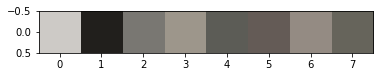

In [65]:
#1900s
display_palette([(205, 202, 198), (33, 31, 28), (121, 119, 114), (157, 150, 139), (92, 92, 86), (100, 91, 86), (148, 139, 131), (102, 100, 91)])

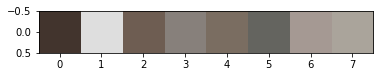

In [66]:
#1910s
display_palette([(66, 52, 45), (222, 222, 222), (110, 93, 82), (135, 128, 123), (122, 109, 97), (100, 100, 95), (165, 153, 147), (170, 164, 155)])

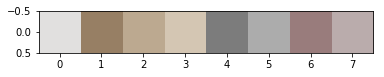

In [67]:
#1920s
display_palette([(225, 224, 223), (151, 127, 100), (188, 169, 144), (212, 198, 179), (124, 124, 124), (172, 172, 172), (153, 124, 124), (186, 172, 172)])

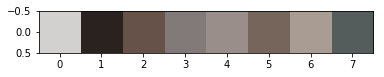

In [68]:
#1930s
display_palette([(211, 208, 208), (41, 34, 31), (103, 82, 74), (129, 122, 120), (153, 142, 138), (117, 101, 90), (168, 156, 147), (84, 92, 92)])

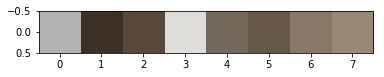

In [69]:
#1940s
display_palette([(181, 179, 177), (59, 49, 38), (87, 72, 59), (223, 221, 218), (115, 103, 92), (101, 87, 72), (136, 120, 106), (151, 136, 119)])

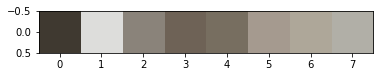

In [70]:
#1950s
display_palette([(63, 57, 48), (221, 221, 219), (138, 131, 122), (110, 98, 86), (119, 110, 96), (165, 154, 143), (174, 167, 153), (177, 175, 167)])

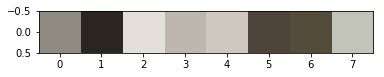

In [71]:
#1960s
display_palette([(143, 139, 130), (42, 37, 32), (228, 223, 219), (189, 183, 174), (207, 200, 190), (77, 67, 57), (84, 76, 59), (195, 196, 185)])

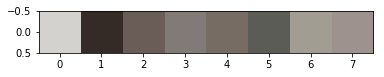

In [72]:
#1970s
display_palette([(212, 210, 207), (52, 42, 38), (106, 92, 86), (130, 122, 118), (119, 108, 99), (92, 92, 87), (162, 157, 147), (157, 146, 141)])

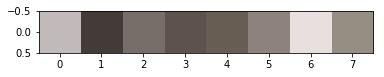

In [73]:
#1980s
display_palette([(193, 186, 186), (67, 59, 55), (119, 110, 106), (94, 82, 76), (103, 93, 82), (141, 130, 124), (232, 223, 223), (150, 141, 131)])

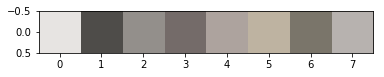

In [74]:
#1990s
display_palette([(231, 228, 226), (78, 76, 73), (147, 143, 139), (116, 107, 105), (173, 163, 158), (190, 179, 161), (122, 117, 106), (183, 178, 175)])

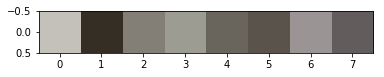

In [75]:
#2000s
display_palette([(196, 193, 186), (53, 46, 37), (131, 126, 118), (156, 156, 147), (106, 101, 92), (90, 83, 75), (155, 148, 148), (99, 92, 92)])

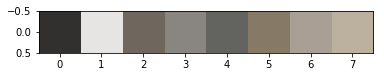

In [76]:
#2010s
display_palette([(50, 48, 46), (231, 229, 227), (111, 103, 94), (137, 134, 130), (99, 100, 96), (134, 122, 102), (169, 159, 148), (188, 177, 158)])

In [6]:
!ls ../../photo_sets/

bee_friendly_flowers  dali	    dress_shirts_no_quarter  seventies
coral		      dress_shirts  jungle		     van_gogh


In [7]:
def make_file_list(root_path, sets_list, set_sel, file_type):
    set_path = sets_list[set_sel]
    path_string = str(root_path + set_path + file_type)
    return glob.glob(path_string)


In [8]:
aws_root_path = '/home/ubuntu/photo_sets/'

aws_sets_list = ['bee_friendly_flowers', 
                 'seventies', 
                 'dress_shirts' , 
                 'dress_shirts_no_quarter', 
                 'dali', 
                 'coral', 
                 'jungle', 
                 'van_gogh', ]

aws_type = '/*.*'

In [ ]:
# photo_root_path = '/Users/Rabbit/capstone/photo_sets/'

# photo_sets_list = ['bee_friendly_flowers', '1970s_google_imgs', 'dress_shirts']

# photo_type = '/*.png'

In [18]:
dress_shirts_nq_lst = make_file_list(aws_root_path, 
                                    aws_sets_list, 
                                    3, 
                                    aws_type)

In [19]:
dress_shirts_nq_lst

['/home/ubuntu/photo_sets/dress_shirts_no_quarter/_r2_c4.png',
 '/home/ubuntu/photo_sets/dress_shirts_no_quarter/_r0_c0.png',
 '/home/ubuntu/photo_sets/dress_shirts_no_quarter/_r0_c2.png',
 '/home/ubuntu/photo_sets/dress_shirts_no_quarter/_r1_c3.png',
 '/home/ubuntu/photo_sets/dress_shirts_no_quarter/_r2_c3.png',
 '/home/ubuntu/photo_sets/dress_shirts_no_quarter/_r2_c2.png',
 '/home/ubuntu/photo_sets/dress_shirts_no_quarter/_r2_c5.png',
 '/home/ubuntu/photo_sets/dress_shirts_no_quarter/_r3_c1.png',
 '/home/ubuntu/photo_sets/dress_shirts_no_quarter/_r3_c5.png',
 '/home/ubuntu/photo_sets/dress_shirts_no_quarter/_r1_c0.png',
 '/home/ubuntu/photo_sets/dress_shirts_no_quarter/_r0_c1.png',
 '/home/ubuntu/photo_sets/dress_shirts_no_quarter/_r0_c6.png',
 '/home/ubuntu/photo_sets/dress_shirts_no_quarter/_r1_c4.png',
 '/home/ubuntu/photo_sets/dress_shirts_no_quarter/_r1_c1.png',
 '/home/ubuntu/photo_sets/dress_shirts_no_quarter/_r1_c5.png',
 '/home/ubuntu/photo_sets/dress_shirts_no_quarter/_r0_c

In [ ]:
dress_shirts_lst

In [42]:
bee_friendly_flowers_list = make_file_list(aws_root_path, 
                                    aws_sets_list, 
                                    0, 
                                    aws_type)

In [ ]:
# bee_friendly_flowers_list

In [50]:
seventies_list = make_file_list(aws_root_path,
                                aws_sets_list,
                                1,
                                '/*.jpg')

In [ ]:
seventies_list_jpg = make_file_list(photo_root_path,
                                photo_sets_list,
                                1,
                                '/*.jpg')

In [20]:
def list_to_central_pipeline(set_lst):
    pal_lst = run_palettization_to_rgb_list(set_lst)
    ss = SetSimilarity()
    central_palette = ss.set_central_list(pal_lst)
    return central_palette

In [21]:
def pure_palette_list(central_palette):
    pure_palette_list = []
    for palette in seventies_central_palette:
        pure_palette_list.append(palette[0])
    return pure_palette_list

In [11]:
list_to_central_pipeline(dress_shirts_nq_lst)

NameError: name 'list_to_central_pipeline' is not defined

In [51]:
pal_lst_seventies = run_palettization_to_rgb_list(seventies_list)

/home/ubuntu/photo_sets/seventies/HT_retro_70s_home_1_jt_160905_4x3_992.jpg
[(211, 77, 78), (49, 19, 20), (117, 40, 51), (225, 120, 173), (242, 199, 136)]
/home/ubuntu/photo_sets/seventies/6709227143_3d1801bd98_b-520x733.jpg
[(221, 6, 4), (240, 152, 11), (237, 92, 16), (178, 36, 4), (243, 201, 17)]
/home/ubuntu/photo_sets/seventies/70s-men-fashion-281__700.jpg


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


[(135, 86, 52), (38, 31, 22), (236, 222, 184), (216, 123, 76), (203, 166, 161)]
/home/ubuntu/photo_sets/seventies/room.jpg
[(233, 133, 27), (59, 19, 12), (161, 50, 14), (250, 224, 203), (251, 215, 91)]
/home/ubuntu/photo_sets/seventies/f35a887378aee1d226631089e486b38e.jpg
[(223, 94, 61), (12, 38, 48), (231, 213, 121), (158, 153, 170), (50, 148, 68)]
/home/ubuntu/photo_sets/seventies/Václav-Zeman-The-First-Generation-1974.jpg
[(50, 44, 40), (231, 223, 214), (219, 65, 47), (194, 132, 152), (234, 171, 79)]
/home/ubuntu/photo_sets/seventies/1main.jpg
[(234, 132, 44), (39, 60, 70), (243, 234, 205), (205, 44, 42), (243, 218, 55)]
/home/ubuntu/photo_sets/seventies/efdbc9532e8260b63d0b48745a5916d7.jpg
[(76, 151, 92), (215, 98, 22), (89, 158, 185), (128, 50, 16), (127, 205, 44)]
/home/ubuntu/photo_sets/seventies/3075165968_c9215cbb36.jpg
[(207, 187, 150), (36, 24, 20), (120, 48, 38), (105, 119, 112), (127, 97, 47)]
/home/ubuntu/photo_sets/seventies/cc8b7ccff0b23511d0c622fcd297c02c.jpg
[(106, 5

In [61]:
# pal_lst_bee = run_palettization_to_rgb_list(bee_friendly_flowers_list)

In [60]:
# pal_lst = run_palettization_to_rgb_list(dress_shirts_nq_lst)

In [52]:
seventy_ss = SetSimilarity()

In [54]:
seventies_list_cent_pal = seventy_ss.set_central_list(pal_lst_seventies)
seventies_list_cent_pal

[(49.632341334420865,
  [(191, 123, 58),
   (50, 28, 18),
   (163, 51, 27),
   (209, 197, 173),
   (205, 189, 137)]),
 (50.503257334298347,
  [(71, 49, 32),
   (230, 146, 50),
   (241, 201, 48),
   (152, 127, 48),
   (246, 238, 209)]),
 (51.135606207794638,
  [(135, 86, 52),
   (38, 31, 22),
   (236, 222, 184),
   (216, 123, 76),
   (203, 166, 161)]),
 (51.575139286005204,
  [(234, 132, 44),
   (39, 60, 70),
   (243, 234, 205),
   (205, 44, 42),
   (243, 218, 55)]),
 (51.901696732534482,
  [(181, 78, 45),
   (43, 20, 17),
   (244, 207, 141),
   (230, 160, 74),
   (189, 171, 164)]),
 (52.229959930871679,
  [(163, 71, 55),
   (37, 77, 53),
   (212, 206, 181),
   (202, 179, 178),
   (183, 161, 117)]),
 (52.300473900293014,
  [(106, 59, 26),
   (225, 78, 7),
   (220, 209, 164),
   (179, 154, 123),
   (164, 172, 84)]),
 (52.690279296870045,
  [(212, 47, 8),
   (247, 206, 160),
   (82, 37, 9),
   (209, 119, 55),
   (209, 146, 133)]),
 (53.817669018251728,
  [(214, 177, 98),
   (59, 42, 27),


In [ ]:
# # /home/ubuntu/photo_sets/dress_shirts_no_quarter/_r2_c6.png
# # [(28, 32, 42), (191, 194, 200), (105, 109, 119), (132, 137, 150), (139, 148, 157)]
# idx = 0
# print(dress_shirts_nq_cent_pal[idx])
# display_palette(dress_shirts_nq_cent_pal[idx][1])

(49.632341334420865, [(191, 123, 58), (50, 28, 18), (163, 51, 27), (209, 197, 173), (205, 189, 137)])


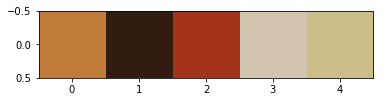

In [55]:
# /home/ubuntu/photo_sets/seventies/45728eac5b9ee8c9e2d3cfed76397272--crochet-vests-crochet-sweaters.jpg
# [(191, 123, 58), (50, 28, 18), (163, 51, 27), (209, 197, 173), (205, 189, 137)]
idx = 0
print(seventies_list_cent_pal[idx])
display_palette(seventies_list_cent_pal[idx][1])

(50.503257334298347, [(71, 49, 32), (230, 146, 50), (241, 201, 48), (152, 127, 48), (246, 238, 209)])


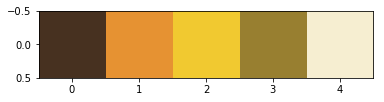

In [56]:
# /home/ubuntu/photo_sets/seventies/M-retro-4.jpg
# [(71, 49, 32), (230, 146, 50), (241, 201, 48), (152, 127, 48), (246, 238, 209)]
idx = 1
print(seventies_list_cent_pal[idx])
display_palette(seventies_list_cent_pal[idx][1])

(51.135606207794638, [(135, 86, 52), (38, 31, 22), (236, 222, 184), (216, 123, 76), (203, 166, 161)])


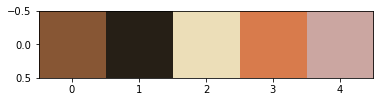

In [57]:
# /home/ubuntu/photo_sets/seventies/70s-men-fashion-281__700.jpg
# [(135, 86, 52), (38, 31, 22), (236, 222, 184), (216, 123, 76), (203, 166, 161)]
idx = 2
print(seventies_list_cent_pal[idx])
display_palette(seventies_list_cent_pal[idx][1])

(51.575139286005204, [(234, 132, 44), (39, 60, 70), (243, 234, 205), (205, 44, 42), (243, 218, 55)])


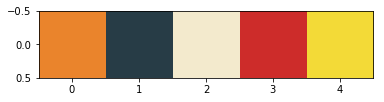

In [58]:
# /home/ubuntu/photo_sets/seventies/1main.jpg
# [(234, 132, 44), (39, 60, 70), (243, 234, 205), (205, 44, 42), (243, 218, 55)]
idx = 3
print(seventies_list_cent_pal[idx])
display_palette(seventies_list_cent_pal[idx][1])

(51.901696732534482, [(181, 78, 45), (43, 20, 17), (244, 207, 141), (230, 160, 74), (189, 171, 164)])


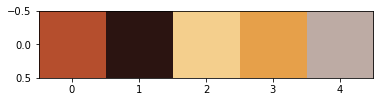

In [59]:
# /home/ubuntu/photo_sets/seventies/aT15w-1458316051-754-blog-sunshinefamily_ad_76.jpg
# [(181, 78, 45), (43, 20, 17), (244, 207, 141), (230, 160, 74), (189, 171, 164)]
idx = 4
print(seventies_list_cent_pal[idx])
display_palette(seventies_list_cent_pal[idx][1])

In [44]:
bee_f_f_ss = SetSimilarity()

In [46]:
bee_f_f_cent_pal = bee_f_f_ss.set_central_list(pal_lst_bee)
bee_f_f_cent_pal

[(11.94482749762774,
  [(220, 217, 215),
   (133, 111, 81),
   (187, 170, 131),
   (184, 111, 111),
   (112, 132, 119)]),
 (12.865447774983654,
  [(224, 217, 213),
   (129, 84, 84),
   (189, 137, 146),
   (138, 125, 95),
   (113, 120, 120)]),
 (13.316269304394339,
  [(220, 218, 216),
   (135, 132, 81),
   (184, 182, 135),
   (135, 113, 122),
   (110, 139, 135)]),
 (13.593876948658224,
  [(222, 220, 219),
   (124, 91, 69),
   (175, 153, 126),
   (100, 117, 118),
   (193, 105, 109)]),
 (14.064243920230815,
  [(223, 216, 211),
   (108, 69, 56),
   (167, 118, 90),
   (200, 138, 128),
   (111, 117, 114)]),
 (14.16979179978286,
  [(221, 216, 208),
   (146, 136, 70),
   (193, 185, 117),
   (103, 114, 107),
   (119, 107, 102)]),
 (14.520212018375741,
  [(219, 218, 216),
   (99, 80, 85),
   (125, 130, 98),
   (162, 142, 141),
   (112, 128, 124)]),
 (14.522308500780113,
  [(224, 220, 217),
   (139, 106, 92),
   (176, 150, 135),
   (122, 128, 128),
   (217, 115, 124)]),
 (14.915710977750816,
  [(

In [23]:
dress_shirts_nq_ss = SetSimilarity()

In [26]:
dress_shirts_nq_cent_pal = dress_shirts_nq_ss.set_central_list(pal_lst)
dress_shirts_nq_cent_pal[0]

[(31.824949344982549,
  [(28, 32, 42),
   (191, 194, 200),
   (105, 109, 119),
   (132, 137, 150),
   (139, 148, 157)]),
 (32.241470624062046,
  [(63, 65, 73),
   (215, 217, 221),
   (138, 140, 146),
   (161, 163, 172),
   (163, 172, 176)]),
 (32.959820960487271,
  [(31, 31, 44),
   (178, 178, 191),
   (108, 108, 121),
   (148, 140, 147),
   (140, 148, 148)]),
 (33.848037337705314,
  [(41, 42, 69),
   (188, 189, 211),
   (116, 115, 143),
   (143, 144, 174),
   (147, 156, 182)]),
 (33.954198591392831,
  [(45, 48, 58),
   (215, 216, 219),
   (171, 173, 176),
   (137, 140, 139),
   (152, 154, 165)]),
 (35.413045390951716,
  [(61, 45, 57),
   (215, 214, 217),
   (166, 163, 168),
   (138, 126, 136),
   (161, 147, 164)]),
 (35.74567801168515,
  [(194, 194, 193),
   (44, 44, 61),
   (114, 114, 123),
   (92, 83, 100),
   (92, 92, 84)]),
 (36.093968977778182,
  [(211, 209, 205),
   (49, 51, 61),
   (128, 128, 130),
   (108, 100, 109),
   (108, 108, 92)]),
 (36.756278954773087,
  [(141, 143, 150

(31.824949344982549, [(28, 32, 42), (191, 194, 200), (105, 109, 119), (132, 137, 150), (139, 148, 157)])


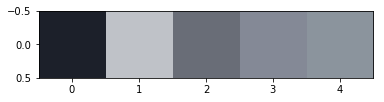

In [48]:
# /home/ubuntu/photo_sets/dress_shirts_no_quarter/_r2_c6.png
# [(28, 32, 42), (191, 194, 200), (105, 109, 119), (132, 137, 150), (139, 148, 157)]
idx = 0
print(dress_shirts_nq_cent_pal[idx])
display_palette(dress_shirts_nq_cent_pal[idx][1])

(32.241470624062046, [(63, 65, 73), (215, 217, 221), (138, 140, 146), (161, 163, 172), (163, 172, 176)])


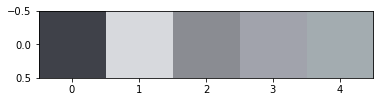

In [38]:
# /home/ubuntu/photo_sets/dress_shirts_no_quarter/_r3_c4.png
# [(63, 65, 73), (215, 217, 221), (138, 140, 146), (161, 163, 172), (163, 172, 176)]
idx = 1
print(dress_shirts_nq_cent_pal[idx])
display_palette(dress_shirts_nq_cent_pal[idx][1])

(32.959820960487271, [(31, 31, 44), (178, 178, 191), (108, 108, 121), (148, 140, 147), (140, 148, 148)])


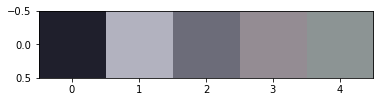

In [39]:
# /home/ubuntu/photo_sets/dress_shirts_no_quarter/_r3_c5.png
# [(31, 31, 44), (178, 178, 191), (108, 108, 121), (148, 140, 147), (140, 148, 148)]
idx = 2
print(dress_shirts_nq_cent_pal[idx])
display_palette(dress_shirts_nq_cent_pal[idx][1])

(33.848037337705314, [(41, 42, 69), (188, 189, 211), (116, 115, 143), (143, 144, 174), (147, 156, 182)])


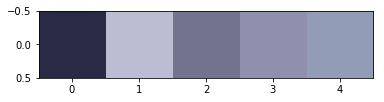

In [40]:
# /home/ubuntu/photo_sets/dress_shirts_no_quarter/_r0_c5.png
# [(41, 42, 69), (188, 189, 211), (116, 115, 143), (143, 144, 174), (147, 156, 182)]
idx = 3
print(dress_shirts_nq_cent_pal[idx])
display_palette(dress_shirts_nq_cent_pal[idx][1])

(33.954198591392831, [(45, 48, 58), (215, 216, 219), (171, 173, 176), (137, 140, 139), (152, 154, 165)])


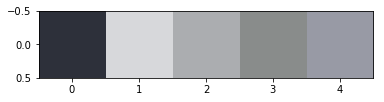

In [41]:
# /home/ubuntu/photo_sets/dress_shirts_no_quarter/_r2_c4.png
# [(45, 48, 58), (215, 216, 219), (171, 173, 176), (137, 140, 139), (152, 154, 165)]
idx = 4
print(dress_shirts_nq_cent_pal[idx])
display_palette(dress_shirts_nq_cent_pal[idx][1])

In [ ]:
pal_lst_png = run_palettization_to_rgb_list(seventies_list_png)

In [ ]:
pal_lst_jpg = run_palettization_to_rgb_list(seventies_list_jpg)

In [ ]:
pal_list = pal_lst_png + pal_lst_jpg

In [ ]:
pal_list

In [ ]:
s_p_ss = SetSimilarity()

In [ ]:
cent_pal = s_p_ss.set_central_list(pal_lst)
cent_pal

In [ ]:
pal_lst = run_palettization_to_rgb_list(dress_shirts_lst)

In [ ]:
d_s_ss = SetSimilarity()

In [ ]:
cent_pal = d_s_ss.set_central_list(pal_lst)
print(cent_pal)

In [ ]:
display_palette(cent_pal[1][1])

In [ ]:
display_img('/Users/Rabbit/capstone/photo_sets/dress_shirts/_r0_c1.png')

In [ ]:
display_palette(cent_pal[1][1])

In [ ]:
display_img('/Users/Rabbit/capstone/photo_sets/dress_shirts/_r0_c2.png')

In [ ]:
display_palette(cent_pal[2][1])

In [ ]:
display_img('')

In [ ]:
pal_lst = run_palettization_to_rgb_list(bee_friendly_flowers_list)

In [ ]:
b_f_f_ss = SetSimilarity()

In [ ]:
cent_pal = b_f_f_ss.set_central_list(pal_lst)

In [ ]:
cent_pal

In [ ]:
display_palette(cent_pal[0][1])

In [ ]:
display_img('/Users/Rabbit/capstone/photo_sets/bee_friendly_flowers/_phlox.png')

In [ ]:
dress_shirt_ss = SetSimilarity()

In [ ]:
cent_pal = dress_shirt_ss.set_central_list(pal_lst)

In [ ]:
central_dress_shirt_palette = list_to_central_pipeline(dress_shirts_lst)

In [ ]:
print(central_dress_shirt_palette)

In [ ]:
pure_central_dress_shirt_palette = pure_palette_list(central_dress_shirt_palette)

In [ ]:
seventies_palettes = run_palettization_to_rgb_list(seventies_links)

In [ ]:
seventies_similarity = SetSimilarity()

In [ ]:
seventies_central_palette = seventies_similarity.set_central_list(seventies_palettes)

In [ ]:
seventies_central_palette

In [ ]:
display_palette(seventies_central_palette[0][1])

In [ ]:
idx = 1
display_palette(sev)

In [ ]:
pure_palette_list.clear()

In [ ]:
display_palette(pure_palette_list)

In [ ]:
len(pure_palette_list)

In [ ]:
pure_hsv_palette_list = []
for palette in seventies_palettes:
    pure_hsv_palette_list.append(palette[0])
    
# pure_hsv_palette_list

In [ ]:
display_palette(seventies_central_palette)

In [ ]:
seventies_raw = ['1main.jpg',
'208b9fb5b409ba3779a5d3e98f41f35b--vintage-ads-retro-ads.jpg',
'3075165968_c9215cbb36.jpg',
'4080666566_6704eebaa1_o.jpg',
'45728eac5b9ee8c9e2d3cfed76397272--crochet-vests-crochet-sweaters.jpg',
'526e535cbb654194d8b622207a550fea.jpg',
'5c4aacc11d49fed320586cb53a482403.jpg',
'620e711e599d1f500ae87071f33dd5a0--s-decor-retro-home-decor.jpg',
'6709227143_3d1801bd98_b-520x733.jpg',
'70s-men-fashion-281__700.jpg',
'70sheader.png',
'91f9d50398c88b2c580e89184b9edf5a.jpg',
'9d9641f3876091907a691766ac3e938f.jpg',
'Concert-Poster-Art-classic-rock-20804540-450-330.jpg',
'HT_retro_70s_home_1_jt_160905_4x3_992.jpg',
'M-retro-4.jpg',
'Newport-Lights-ad-yellow-t-shirt.jpg',
'Screen-Shot-2012-01-27-at-12.43.26-PM1.png',
'Václav-Zeman-The-First-Generation-1974.jpg',
'Ydz9c-1468504224-1001-blog-spacefoodsticks_main_1200.jpg',
'aT15w-1458316051-754-blog-sunshinefamily_ad_76.jpg',
'aria-pura_fmt.jpg',
'aruba.jpg',
'b30d8a5b3cfce748b55f598119acd0ba--vintage-outfits-fashion-vintage.jpg',
'b9cef75289fc9f54858fc388ef42f942--feminism-poster-political-posters.jpg',
'bowie.jpg',
'brady_bunch_1970s.jpg',
'cc8b7ccff0b23511d0c622fcd297c02c.jpg',
'ce6691c717766c095c8735eecb406aac.jpg',
'd218b4051bfa39178b82c77f9c97c34d--big-mouths-vintage-toys-s.jpg',
'doublemint_ad_2_1975_copy.jpg',
'e10-254_500.jpg',
'efdbc9532e8260b63d0b48745a5916d7.jpg',
'f35a887378aee1d226631089e486b38e.jpg',
'human_factor_poster_01.jpg',
'landscape-1463088645-1970s-toys-collage.jpg',
'london-colourful-life-in-the-1970s-07-1024x614_c.jpg',
'milton-16340-31.jpeg',
'poster-grandfather-computer-22832.jpg',
'posters10n-3-web.jpg',
'room.jpg',
'slang-1970s.png']

In [ ]:
rgb = (0, 255, 0)
c = Color(rgb)
print(c.hsv)
# print(plt.imshow([[c.hsv]]))

In [ ]:
print(pure_palette_list)

In [ ]:
test_images = ['/Users/Rabbit/Downloads/china_test.jpg', 
               '/Users/Rabbit/Downloads/vilnius_test.jpg', 
               '/Users/Rabbit/Downloads/spices_test.jpg']

In [ ]:
loc_fashion_images = ['/Users/Rabbit/capstone/materials/scrape_fashion_2/2003.86.1.png', 
                     '/Users/Rabbit/capstone/materials/scrape_fashion_2/2006.44.1.png', 
                     '/Users/Rabbit/capstone/materials/scrape_fashion_2/2006.56.1.png', 
                     '/Users/Rabbit/capstone/materials/scrape_fashion_2/2006.56.2.png', 
                     '/Users/Rabbit/capstone/materials/scrape_fashion_2/2007.30.1.png', 
                     '/Users/Rabbit/capstone/materials/scrape_fashion_2/2008.4.1.png', 
                     '/Users/Rabbit/capstone/materials/scrape_fashion_2/2010.98.1.png', 
                     '/Users/Rabbit/capstone/materials/scrape_fashion_2/74.32.4.png', 
                     '/Users/Rabbit/capstone/materials/scrape_fashion_2/76.64.1.png', 
                     '/Users/Rabbit/capstone/materials/scrape_fashion_2/80.1.4.png']

In [ ]:
ColorThief?

In [ ]:
# img_path = loc_fashion_images[1]

In [ ]:
img_path = test_images[1]

In [ ]:
test_images

In [ ]:
decade_palettes = [ [(0.0, [(201, 195, 193), (31, 30, 29), (165, 151, 138), (148, 135, 126), (94, 89, 87), (119, 115, 112), (84, 84, 80), (101, 100, 92)])],
                    [(3442.1891140569815, [(205, 202, 198), (33, 31, 28), (121, 119, 114), (157, 150, 139), (92, 92, 86), (100, 91, 86), (148, 139, 131), (102, 100, 91)])],
                    [(3899.103815534721, [(214, 210, 207), (80, 66, 50), (153, 139, 121), (112, 96, 79), (126, 111, 89), (188, 174, 156), (148, 148, 148), (156, 148, 149)])],
                    [(7872.9902950932819, [(66, 52, 45), (222, 222, 222), (110, 93, 82), (135, 128, 123), (122, 109, 97), (100, 100, 95), (165, 153, 147), (170, 164, 155)])],
                    [(15468.418055458445, [(44, 44, 44), (205, 204, 201), (125, 125, 124), (99, 100, 94), (156, 156, 153), (164, 156, 152), (148, 148, 156), (92, 92, 100)])],
                    [(11377.787368176734, [(192, 187, 186), (39, 45, 46), (135, 135, 134), (163, 164, 163), (106, 109, 109), (90, 92, 94), (157, 156, 164), (98, 100, 108)])],
                    [(16861.608719121228, [(49, 46, 43), (195, 192, 189), (130, 128, 127), (155, 158, 161), (91, 86, 82), (148, 148, 156), (104, 99, 100), (107, 108, 106)])],
                    [(38874.991751545182, [(206, 201, 199), (40, 38, 37), (94, 89, 86), (117, 114, 112), (151, 148, 139), (103, 100, 92), (148, 139, 138), (84, 92, 84)])],
                    [(19747.072618635553, [(48, 49, 52), (210, 204, 202), (118, 120, 125), (166, 161, 160), (101, 90, 92), (105, 100, 91), (149, 138, 138), (154, 148, 139)])],
                    [(17851.38526962269, [(181, 176, 172), (68, 65, 58), (116, 111, 103), (221, 220, 225), (131, 128, 125), (92, 84, 84), (84, 83, 84), (140, 124, 124)])],
                    [(20429.461822270936, [(208, 201, 198), (27, 27, 29), (128, 124, 121), (92, 92, 89), (100, 92, 92), (156, 148, 140), (101, 100, 92), (156, 140, 140)])],
                    [(24466.800045832199, [(196, 193, 186), (53, 46, 37), (131, 126, 118), (156, 156, 147), (106, 101, 92), (90, 83, 75), (155, 148, 148), (99, 92, 92)])],
                    [(9728.2550088663593, [(213, 211, 209), (89, 88, 82), (133, 133, 127), (108, 109, 108), (173, 171, 165), (155, 157, 156), (116, 108, 108), (164, 156, 156)])] ]

In [ ]:
palette_1880 = pure_palette_list[0]

In [ ]:
hsv_palettes = [
[(0.0, [(201, 195, 193), (31, 30, 29), (165, 151, 138), (148, 135, 126), (94, 89, 87), (119, 115, 112), (84, 84, 80), (101, 100, 92)])],
[(21.932750312643389, [(205, 202, 198), (33, 31, 28), (121, 119, 114), (157, 150, 139), (92, 92, 86), (100, 91, 86), (148, 139, 131), (102, 100, 91)])],
[(24.14241698432032, [(66, 52, 45), (222, 222, 222), (110, 93, 82), (135, 128, 123), (122, 109, 97), (100, 100, 95), (165, 153, 147), (170, 164, 155)])],
[(55.344889047438663, [(225, 224, 223), (151, 127, 100), (188, 169, 144), (212, 198, 179), (124, 124, 124), (172, 172, 172), (153, 124, 124), (186, 172, 172)])],
[(133.74628216139538, [(211, 208, 208), (41, 34, 31), (103, 82, 74), (129, 122, 120), (153, 142, 138), (117, 101, 90), (168, 156, 147), (84, 92, 92)])],
[(87.906318108503413, [(181, 179, 177), (59, 49, 38), (87, 72, 59), (223, 221, 218), (115, 103, 92), (101, 87, 72), (136, 120, 106), (151, 136, 119)])],
[(126.15456696139745, [(63, 57, 48), (221, 221, 219), (138, 131, 122), (110, 98, 86), (119, 110, 96), (165, 154, 143), (174, 167, 153), (177, 175, 167)])],
[(277.76148378796586, [(143, 139, 130), (42, 37, 32), (228, 223, 219), (189, 183, 174), (207, 200, 190), (77, 67, 57), (84, 76, 59), (195, 196, 185)])],
[(146.86350031680615, [(212, 210, 207), (52, 42, 38), (106, 92, 86), (130, 122, 118), (119, 108, 99), (92, 92, 87), (162, 157, 147), (157, 146, 141)])],
[(121.14453392085414, [(193, 186, 186), (67, 59, 55), (119, 110, 106), (94, 82, 76), (103, 93, 82), (141, 130, 124), (232, 223, 223), (150, 141, 131)])],
[(133.37420110918586, [(231, 228, 226), (78, 76, 73), (147, 143, 139), (116, 107, 105), (173, 163, 158), (190, 179, 161), (122, 117, 106), (183, 178, 175)])],
[(172.57672755092165, [(196, 193, 186), (53, 46, 37), (131, 126, 118), (156, 156, 147), (106, 101, 92), (90, 83, 75), (155, 148, 148), (99, 92, 92)])],
[(62.529411138383566, [(50, 48, 46), (231, 229, 227), (111, 103, 94), (137, 134, 130), (99, 100, 96), (134, 122, 102), (169, 159, 148), (188, 177, 158)])]
]

In [ ]:
rgb = (201, 195, 193)
c = Color(rgb)
print(c.hsv)
# print(plt.imshow([[c.hsv]]))

In [ ]:
rgb = (31, 30, 29)
c = Color(rgb)
print(c.hsv)
# print(plt.imshow([[c.hsv]]))

In [ ]:
idx = 2

In [ ]:
print(display_palette(pure_hsv_palette_list[idx]))

In [ ]:
print(labeled_palettes[idx])
print(display_palette(pure_palette_list[idx]))

In [ ]:
print(labeled_palettes[0])
print(display_palette(pure_palette_list[0]))

In [ ]:
print(labeled_palettes[1])
print(display_palette(pure_palette_list[1]))

In [ ]:
print(labeled_palettes[2])
print(display_palette(pure_palette_list[2]))

In [ ]:
print(labeled_palettes[3])
print(display_palette(pure_palette_list[3]))

In [ ]:
print(labeled_palettes[4])
print(display_palette(pure_palette_list[4]))

In [ ]:
print(labeled_palettes[5])
print(display_palette(pure_palette_list[5]))

In [ ]:
print(labeled_palettes[6])
print(display_palette(pure_palette_list[6]))

In [ ]:
print(labeled_palettes[7])
print(display_palette(pure_palette_list[7]))

In [ ]:
print(labeled_palettes[8])
print(display_palette(pure_palette_list[8]))

In [ ]:
print(labeled_palettes[9])
print(display_palette(pure_palette_list[9]))

In [ ]:
print(labeled_palettes[10])
print(display_palette(pure_palette_list[10]))

In [ ]:
print(labeled_palettes[11])
print(display_palette(pure_palette_list[11]))

In [ ]:
print(labeled_palettes[12])
print(display_palette(pure_palette_list[12]))

In [ ]:
run_palettization_to_rgb_list(test_images)

In [ ]:
decades = ['1880', '1900', '1910', '1920', '1930', '1940', '1950', '1960', '1970', '1980', '1990', '2000', '2010']

In [ ]:
len(decades)

In [ ]:
labeled_palettes = list(zip(decades, pure_palette_list))

In [ ]:
labeled_palettes

In [ ]:
run_palettization_to_rgb_list(loc_fashion_images)

In [ ]:
# %pdb

In [ ]:
c = Color((0,0,0))

In [ ]:
c.hsv

In [ ]:
palette_me_now = Palettization(img_path)

In [ ]:
# %pdb

In [ ]:
palette_me_now.zip_centroid_count()

In [ ]:
# img_palette

In [ ]:
palette_me_now.get_hsv_palette()

In [ ]:
from colorthief import ColorThief

In [ ]:
era = decade_palettes[0]

In [ ]:
era_palette = ColorThief(era)

In [ ]:
!ls ../..

In [ ]:
seventies_links = []

for img in seventies_raw:
    seventies_links.append('/Users/Rabbit/capstone/1970s_google_imgs/'+ str(img))

In [ ]:
seventies_links[0]

In [ ]:
try_me = [Palettization(link) for link in seventies_links]

In [ ]:
try_me

In [ ]:
i = 2
try_me[i].display_palette()

try_me[i].zip_centroid_count()

In [ ]:
try_me[i].display_img()

In [ ]:
for item in try_me:
    item.display_palette()

In [ ]:
palette_color_percent

In [ ]:
palette_color_percent = {}
# label_
img_pixel_sum = 0

for image in try_me:
    for i in image.zip_centroid_count():
        img_pixel_sum += i['count']
#     print(img_pixel_sum)
        palette_color_percent[i['rgb']] = i['count'] / 540000

sorted(palette_color_percent, key=lambda x: palette_color_percent[x], reverse=True)

In [ ]:
type(var)

In [ ]:
# p_1 = [ (200, 161, 70),
#         (36, 46, 40),
#         (156, 14, 12) ]

# p_2 = [ (152, 173, 201),
#         (172, 171, 171),
#         (122, 56, 37) ]

# p_3 = [ (123, 145, 125),
#         (228, 228, 236),
#         (210, 113, 29) ]

# p_3_a = [ (228, 228, 236),
#           (123, 145, 125),
#           (210, 113, 29) ]

# p_4 = [ (228, 223, 204),
#         (157, 119, 81),
#         (130, 146, 146),
#         (210, 165, 89) ]

# p_5 = [ (33, 13, 12),
#         (42, 28, 29),
#         (132, 122, 120),
#         (170, 83, 69),
#         (145, 130, 127),
#         (109, 112, 101) ]

# p_6 = [ (62, 85, 101),
#         (148, 98, 110),
#         (171, 176, 172),
#         (124, 60, 132),
#         (73, 97, 67) ]

# p_test_lst = [ p_1, p_2, p_3, p_3_a, p_4, p_5, p_6 ]

In [ ]:
# p_test = SetSimilarity()

In [ ]:
print(p_test.c2c_dist(p_1[0], p_1[2]))

print(p_test.c2p_dist(p_1[0], p_2))

print(p_test.p2p_dist(p_1, p_6))

print(p_test.set_central_list(p_test_lst))

In [ ]:
palette_1 = [ ( 255, 0, 0), (0, 255, 0) ]
palette_2 = [ (0, 255, 0), (0, 0, 255), (42, 142, 242), (108, 212, 228) ]
palette_3 = [ (255, 0, 0), (0, 0, 255) ]
palette_4 = [ (127,127,127), (0, 0, 255) ]
palette_5 = [ ( 255, 0, 0), (0, 255, 0) ]
palette_list_ex = [palette_1, palette_2, palette_3, palette_4, palette_5]
color_a = palette_1[0]
color_b = palette_1[1]

In [ ]:
test_other = SetSimilarity()

In [ ]:
print(test_other.c2c_dist(palette_2[0], palette_1[1]))

print(test_other.c2p_dist(color_a, palette_2))

print(test_other.p2p_dist(palette_2, palette_4))

print(test_other.set_central_list(palette_list_ex))

In [ ]:
from colour import Color

In [ ]:
c = Color()

In [ ]:
morning_pic = ['/Users/Rabbit/Desktop/Screen Shot 2017-10-25 at 07.56.08.png',
              '/Users/Rabbit/Desktop/Screen Shot 2017-10-25 at 08.08.44.png', 
              '/Users/Rabbit/Desktop/Screen Shot 2017-10-25 at 08.17.04.png',
              '/Users/Rabbit/Desktop/Screen Shot 2017-10-25 at 08.33.38.png']

In [ ]:
c_harmony = Palettization(morning_pic[0])

In [ ]:
c_harmony.display_palette()

In [ ]:
c_harmony.zip_centroid_count()

In [ ]:
c_harmony.display_img()

In [ ]:
import colorsys

In [ ]:
try_me[1].arrayify_centroids()

In [ ]:
get_palette(img_path)

In [ ]:
plt.imshow([(centroid_lst).astype('uint8')])

In [ ]:
import colorgram

img = (morning_pic[0])

In [ ]:
colors = colorgram.extract(img, 6)

In [ ]:
colors[0]

In [ ]:
# for color in palette_color_percent:
#     r_chan = color[0]
#     b_chan = color[1]
#     g_chan = color[2]
#     r_vals.append(r_chan)
#     b_vals.append(b_chan)
#     g_vals.append(g_chan)

def colorT_rgb2hsv(rgb_vector):
    """returns an hsv vector from rgb"""
    hsv_vector = []
    for color in rgb_vector:
        r_prime = color[0]/255
        b_prime = color[1]/255
        g_prime = color[2]/255
        
        

In [ ]:
import colorsys

def rgb_hsv(rgb_tup):
    """returns hsv tuple from rgb"""
    """thanks for your help Zach E.!"""
    

    r = rgb_tup[0]
    b = rgb_tup[1]
    g = rgb_tup[2]
#         print(r, g, b)
    h, s, v = colorsys.rgb_to_hsv(r / 255., g / 255., b / 255.)
    h = h * 360
    hsv = [h, s, v]
    return tuple(hsv)

In [ ]:
var

In [ ]:
rgb_hsv(var)

In [ ]:
_1 = np.uint8([[_var]])
hsv_1 = cv2.cvtColor(_1, cv2.COLOR_RGB2HSV)

In [ ]:
hsv_1

In [ ]:
green = np.uint8([[[0,255,0 ]]])
hsv_green = cv2.cvtColor(green,cv2.COLOR_RGB2HSV)
print(hsv_green)

In [ ]:
var = (108, 212, 228)

In [ ]:
from colorutils import Color

def get_hsv(rgb):
    c = Color(rgb)
    return c.hsv

In [ ]:
get_hsv(var)
    
    
    

In [ ]:
rgb2hsv(var)